In [6]:
"""
TODO

notebook >> models/final.h5
[ ] Build Keras model
[ ] Train >> models/test_<date>_<timestamp>.h5
[ ] Put all augmentation functions in utils.py
[ ] Collect more data
[ ] Final train and store as .h5

drive.py
[ ] Modify speed to slow down whenever hit a bad steering angle

image ~ sample/temp variable
"""
print(".")

.


Image Processing Code Segment
---

Describe different functions...

In [267]:
import os, sys, glob

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
IMAGE_COLS = ('center', 'left', 'right')
STEER_COLS = ('steering')


def load_image(data_dir, image_file):
    """Load RGB images from a file"""
    
    return mpimg.imread(os.path.join(data_dir, image_file.strip()))


def resize(image):
    """Resize image to determined sizes"""
    
    return cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)


def crop(image):
    """Crop the image (removing the sky at the top and the car front at the bottom)
    
    Credit: https://github.com/naokishibuya/car-behavioral-cloning
    """
    
    return image[60:-25, :, :] # remove the sky and the car front


def rgb2yuv(image):
    """Convert the image from RGB to YUV to support the NVIDIA model.
    
    Credit: https://github.com/naokishibuya/car-behavioral-cloning
    """
    
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)


def process_image(image):
    image = crop(image)
    image = resize(image)
    image = rgb2yuv(image)
    return image


def batch_generator(data_dir, image_df, steering_df, batch_size=64, is_training=True):
    """Generate batch to load. 
    
    A generator is like a coroutine, a process that can run separately from another main routine. More memory efficient
    
    Args:
        data_dir
        image_df: (n, 3) dataframe of ('center', 'left', 'right')
        steering_df: (n, 1) dataframe of ('steering)
        batch_size
        is_training
    
    Returns:
        generator
    """
    while 1:
        feats = np.zeros((batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
        responses = np.zeros((batch_size))
        
        batch_image = image_df.sample(batch_size)
        batch_steer = steering_df[batch_image.index].reset_index(drop=True)
        batch_image.reset_index(inplace=True, drop=True)
        
        for i, row in batch_image.iterrows():
            feats[i, :, :, :] = process_image(load_image(data_dir, row[IMAGE_COLS[0]]))
            responses[i] = float(batch_steer[i])

        yield feats, responses

In [242]:
data_dir = 'data/sample_data'
log_path = os.path.join(data_dir, 'driving_log.csv')

In [243]:
log_df = pd.read_csv(log_path)
print(len(log_df))

8036


Visualization
---
Describe different augmentation effects

Steering = 0.0, Throttle = 0.9855325999999999, Brake = 0.0, Speed = 30.18665 


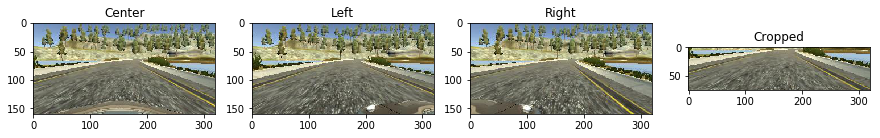

Steering = 0.0, Throttle = 0.0, Brake = 0.0, Speed = 29.502309999999998 


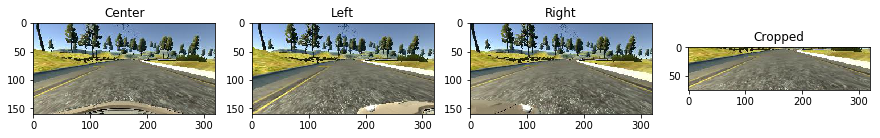

Steering = 0.0, Throttle = 0.9855325999999999, Brake = 0.0, Speed = 30.18664 


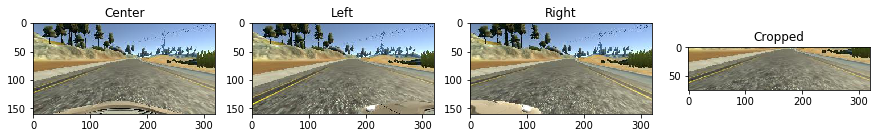

In [244]:
# Visualization
for _, row in log_df.sample(3).iterrows():
    center_image = load_image(data_dir, row['center'])
    left_image = load_image(data_dir, row['left'])
    right_image = load_image(data_dir, row['right'])
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 15))
    ax1.imshow(center_image)
    ax1.set_title('Center')
    ax2.imshow(left_image)
    ax2.set_title('Left')
    ax3.imshow(right_image)
    ax3.set_title('Right')
    ax4.imshow(crop(center_image))
    ax4.set_title('Cropped')
    print("Steering = {0[0]}, Throttle = {0[1]}, Brake = {0[2]}, Speed = {0[3]} ".format(row[3:]))
    plt.show()

Generator Usage
---
Describe the `batch_generator()` method. How is it more memory efficient

In [245]:
sample_gen = batch_generator(data_dir, log_df.loc[:, IMAGE_COLS], log_df.loc[:, STEER_COLS])

for _ in range(5):
    X, y = next(sample_gen)
    print(X.shape, y.shape)

(64, 66, 200, 3) (64,)
(64, 66, 200, 3) (64,)
(64, 66, 200, 3) (64,)
(64, 66, 200, 3) (64,)
(64, 66, 200, 3) (64,)


In [246]:
"""
Goal: use images as features to predict steering angles

Adjust brake and speed manually?

"""

'\nGoal: use images as features to predict steering angles\n\nAdjust brake and speed manually?\n\n'

Model Code Segment
---

Describe the NVIDIA structure.

Add Karparthy model. Valid = padding. Same = not pad

$$\frac{H/W - K + 2P}{S} + 1$$

In [247]:
from keras.models import Sequential # Import model class
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten # Import layers
from keras.optimizers import Adam # Import optimizer
from keras.callbacks import ModelCheckpoint # Import checkpoint

# Starting shape: (_, 66, 200, 3)
# Neuron layers sequence: (3, 24, 36, 48, 64)

model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=INPUT_SHAPE, name='Normalization')) # Standardize, no need for sklearn Standardizer?
model.add(Conv2D(filters=24, kernel_size=(5, 5), strides=(2, 2), activation='elu', name='Conv_L1')) 
model.add(Conv2D(filters=36, kernel_size=(5, 5), strides=(2, 2), activation='elu', name='Conv_L2'))
model.add(Conv2D(filters=48, kernel_size=(5, 5), strides=(2, 2), activation='elu', name='Conv_L3'))
model.add(Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1), activation='elu', name='Conv_L4')) # Reduce stride to have more fine-grain detail
model.add(Dropout(rate=0.5, name='Dropout_L1'))
model.add(Flatten(name='Flatten')) # Fully-connected layers
model.add(Dense(units=100, activation='elu', name='Dense_L1'))
model.add(Dense(units=50, activation='elu', name='Dense_L2'))
model.add(Dense(units=10, activation='elu', name='Dense_L3'))
model.add(Dense(units=1, activation='elu', name='Dense_L4'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Normalization (Lambda)       (None, 66, 200, 3)        0         
_________________________________________________________________
Conv_L1 (Conv2D)             (None, 31, 98, 24)        1824      
_________________________________________________________________
Conv_L2 (Conv2D)             (None, 14, 47, 36)        21636     
_________________________________________________________________
Conv_L3 (Conv2D)             (None, 5, 22, 48)         43248     
_________________________________________________________________
Conv_L4 (Conv2D)             (None, 1, 18, 64)         76864     
_________________________________________________________________
Dropout_L1 (Dropout)         (None, 1, 18, 64)         0         
_________________________________________________________________
Flatten (Flatten)            (None, 1152)              0         
__________

Training Operations Code Segment
---

Sequence:
- Checkpoint
- Compile. MSE because we optimizer a continuous variable. Cross-entropy if we optimize classification
- Fit_generator

```python
# For a multi-class classification problem
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# For a binary classification problem
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# For a mean squared error regression problem
model.compile(optimizer='rmsprop',
              loss='mse')

# For custom metrics
import keras.backend as K

def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy', mean_pred])
```

In [248]:
def train(model, optimizer, train_gen, val_gen, num_epoch=1, storage_path='models', verbose=True, **config):
    """Perform training operations given defined model"""
    
    if not os.path.exists(storage_path):
        os.makedirs(storage_path)
        
    # Checkpoint
    checkpoint = ModelCheckpoint(os.path.join(storage_path, '{epoch:03d}.h5'), monitor='val_loss',
                                 save_best_only=True, 
                                 verbose=int(verbose), mode='auto') # Auto infer min_loss or max_acc of val set
    
    if optimizer is None:
        model.compile(optimizer='adagrad', loss='mse')
    else:
        model.compile(optimizer, loss='mse')
    
    model.fit_generator(train_gen, steps_per_epoch=config.get('train_steps', 50), epochs=num_epoch,
                        validation_data=val_gen, validation_steps=config.get('val_steps', 10),
                        callbacks=[checkpoint], max_q_size=config.get('max_queue_size', 10),
                        verbose=int(verbose),
                        workers=config.get('workers', 1), use_multiprocessing=config.get('multi_processing', False))

In [268]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(log_df.loc[:, IMAGE_COLS], log_df.loc[:, STEER_COLS])
train_gen = batch_generator(data_dir, X_train, y_train)
valid_gen = batch_generator(data_dir, X_valid, y_valid, is_training=False)

In [269]:
train(model, Adam(lr=0.001, decay=0.01), train_gen, valid_gen, num_epoch=5)

/home/toanlm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=50, epochs=5, validation_data=<generator..., validation_steps=10, callbacks=[<keras.ca..., verbose=1, workers=1, use_multiprocessing=False, max_queue_size=10)`


Epoch 1/5
50/50 [==============================] - 21s 411ms/step - loss: 0.0209 - val_loss: 0.0100

Epoch 00001: val_loss improved from inf to 0.00998, saving model to models/001.h5
Epoch 2/5
50/50 [==============================] - 17s 345ms/step - loss: 0.0106 - val_loss: 0.0119

Epoch 00002: val_loss did not improve
Epoch 3/5
50/50 [==============================] - 17s 347ms/step - loss: 0.0110 - val_loss: 0.0094

Epoch 00003: val_loss improved from 0.00998 to 0.00936, saving model to models/003.h5
Epoch 4/5
50/50 [==============================] - 18s 363ms/step - loss: 0.0101 - val_loss: 0.0105

Epoch 00004: val_loss did not improve
Epoch 5/5
50/50 [==============================] - 19s 377ms/step - loss: 0.0095 - val_loss: 0.0085

Epoch 00005: val_loss improved from 0.00936 to 0.00852, saving model to models/005.h5
